**Setting up our working environment by importing the necessary Python libraries that will be used throughout the notebook**



In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [20]:
data = pd.read_csv('/content/Fraud Detection Dataset.csv', index_col="Transaction_ID")
data.head(10)

,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
Transaction_ID,,,,,,,,,,,
T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
T3,1860,2395.02,ATM Withdrawal,NaN,Mobile,NaN,3,115,9,NaN,0
T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0
T6,2095,2372.04,ATM Withdrawal,15.0,Desktop,Boston,3,96,14,Credit Card,0
T7,4772,544.81,Bill Payment,2.0,Tablet,Boston,3,6,9,UPI,1
T8,4092,635.75,ATM Withdrawal,13.0,Tablet,Boston,2,13,10,Debit Card,0
T9,2638,2318.87,Bank Transfer,NaN,Mobile,San Francisco,4,110,12,Debit Card,0


**Data exploration**
**Performing a preliminary exploration of the dataset to get a better understanding of the data I am working with.**

**This initial exploration of the data will help uncover underlying patterns and relationships that can inform the choice of models.**

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51000 entries, T1 to T13665
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   User_ID                           51000 non-null  int64  
 1   Transaction_Amount                48480 non-null  float64
 2   Transaction_Type                  51000 non-null  object 
 3   Time_of_Transaction               48448 non-null  float64
 4   Device_Used                       48527 non-null  object 
 5   Location                          48453 non-null  object 
 6   Previous_Fraudulent_Transactions  51000 non-null  int64  
 7   Account_Age                       51000 non-null  int64  
 8   Number_of_Transactions_Last_24H   51000 non-null  int64  
 9   Payment_Method                    48531 non-null  object 
 10  Fraudulent                        51000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 4.7+ MB


**From the result above, I observed missing values, to correct this, I created a function below to fill categorical columns with the mode of their columns and numerical columns with the mean of their columns**

In [22]:
for col in data.columns:
    if data[col].dtype == 'object': # Categorical columns
        data[col].fillna(data[col].mode()[0], inplace=True)
    elif data[col].dtype in ['int64', 'float64']: # Numerical columns
        data[col].fillna(data[col].mean(), inplace=True)

# Verify that there are no more missing values
print("Missing values after imputation:")
print(data.isnull().sum())

Missing values after imputation:
User_ID                             0
Transaction_Amount                  0
Transaction_Type                    0
Time_of_Transaction                 0
Device_Used                         0
Location                            0
Previous_Fraudulent_Transactions    0
Account_Age                         0
Number_of_Transactions_Last_24H     0
Payment_Method                      0
Fraudulent                          0
dtype: int64


/tmp/ipython-input-2706014443.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
/tmp/ipython-input-2706014443.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [23]:
# Running data.info again to verify
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51000 entries, T1 to T13665
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   User_ID                           51000 non-null  int64  
 1   Transaction_Amount                51000 non-null  float64
 2   Transaction_Type                  51000 non-null  object 
 3   Time_of_Transaction               51000 non-null  float64
 4   Device_Used                       51000 non-null  object 
 5   Location                          51000 non-null  object 
 6   Previous_Fraudulent_Transactions  51000 non-null  int64  
 7   Account_Age                       51000 non-null  int64  
 8   Number_of_Transactions_Last_24H   51000 non-null  int64  
 9   Payment_Method                    51000 non-null  object 
 10  Fraudulent                        51000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 4.7+ MB


In [24]:
data.describe()

,User_ID,Transaction_Amount,Time_of_Transaction,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Fraudulent
count,51000.000000,51000.000000,51000.000000,51000.000000,51000.000000,51000.000000,51000.000000
mean,3005.110176,2996.249784,11.488400,1.995725,60.033902,7.495588,0.049216
std,1153.121107,4917.736637,6.747518,1.415150,34.384131,4.020080,0.216320
min,1000.000000,5.030000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,2007.000000,1333.787500,6.000000,1.000000,30.000000,4.000000,0.000000
50%,2996.000000,2656.165000,11.488400,2.000000,60.000000,7.000000,0.000000
75%,4006.000000,3724.987500,17.000000,3.000000,90.000000,11.000000,0.000000
max,4999.000000,49997.800000,23.000000,4.000000,119.000000,14.000000,1.000000


**For a regression task, I will need a response variable, for this, I will create fraud rate column**

This is calculated by taking the average of the Fraudulent column for each unique User_ID. This value will then be assigned to all transactions associated with that specific user.




In [25]:
# Calculate fraud rate per User_ID
# The mean of the binary 'Fraudulent' column (0 or 1) directly gives the proportion of fraudulent transactions per user.
fraud_rate_per_user = data.groupby('User_ID')['Fraudulent'].mean().reset_index()
fraud_rate_per_user.rename(columns={'Fraudulent': 'fraud_rate'}, inplace=True)

# Merge this new 'fraud_rate' back into the original 'data' DataFrame
# This assigns the calculated fraud rate of each user to all their transactions.
data = pd.merge(data, fraud_rate_per_user, on='User_ID', how='left')

# Drop the original 'Fraudulent' column as 'fraud_rate' is now the target variable for regression.
data.drop('Fraudulent', axis=1, inplace=True)

# Display the updated DataFrame info to confirm the new column and dropped column
print("DataFrame after creating 'fraud_rate' and dropping 'Fraudulent':")
data.info()
display(data.head())

DataFrame after creating 'fraud_rate' and dropping 'Fraudulent':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   User_ID                           51000 non-null  int64  
 1   Transaction_Amount                51000 non-null  float64
 2   Transaction_Type                  51000 non-null  object 
 3   Time_of_Transaction               51000 non-null  float64
 4   Device_Used                       51000 non-null  object 
 5   Location                          51000 non-null  object 
 6   Previous_Fraudulent_Transactions  51000 non-null  int64  
 7   Account_Age                       51000 non-null  int64  
 8   Number_of_Transactions_Last_24H   51000 non-null  int64  
 9   Payment_Method                    51000 non-null  object 
 10  fraud_rate                        51000 non-null  float64
dtypes:

,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,fraud_rate
0,4174,1292.76,ATM Withdrawal,16.0000,Tablet,San Francisco,0,119,13,Debit Card,0.166667
1,4507,1554.58,ATM Withdrawal,13.0000,Mobile,New York,4,79,3,Credit Card,0.083333
2,1860,2395.02,ATM Withdrawal,11.4884,Mobile,Boston,3,115,9,UPI,0.000000
3,2294,100.10,Bill Payment,15.0000,Desktop,Chicago,4,3,4,UPI,0.000000
4,2130,1490.50,POS Payment,19.0000,Mobile,San Francisco,2,57,7,Credit Card,0.100000


**Dummy variables**:
**Next step is to convert the categorical columns into numerical coluns using dummy variable**

In [26]:
# Identify categorical columns
categorical_cols = data.select_dtypes(include='object').columns

# Convert categorical columns to dummy variables
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Display the first few rows of the updated DataFrame and its info to confirm changes
print("DataFrame after converting categorical columns:")
display(data.head())
print("\nDataFrame info after converting categorical columns:")
data.info()

DataFrame after converting categorical columns:


,User_ID,Transaction_Amount,Time_of_Transaction,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,fraud_rate,Transaction_Type_Bank Transfer,Transaction_Type_Bill Payment,Transaction_Type_Online Purchase,...,Location_Houston,Location_Los Angeles,Location_Miami,Location_New York,Location_San Francisco,Location_Seattle,Payment_Method_Debit Card,Payment_Method_Invalid Method,Payment_Method_Net Banking,Payment_Method_UPI
0,4174,1292.76,16.0000,0,119,13,0.166667,False,False,False,...,False,False,False,False,True,False,True,False,False,False
1,4507,1554.58,13.0000,4,79,3,0.083333,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,1860,2395.02,11.4884,3,115,9,0.000000,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,2294,100.10,15.0000,4,3,4,0.000000,False,True,False,...,False,False,False,False,False,False,False,False,False,True
4,2130,1490.50,19.0000,2,57,7,0.100000,False,False,False,...,False,False,False,False,True,False,False,False,False,False



DataFrame info after converting categorical columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   User_ID                           51000 non-null  int64  
 1   Transaction_Amount                51000 non-null  float64
 2   Time_of_Transaction               51000 non-null  float64
 3   Previous_Fraudulent_Transactions  51000 non-null  int64  
 4   Account_Age                       51000 non-null  int64  
 5   Number_of_Transactions_Last_24H   51000 non-null  int64  
 6   fraud_rate                        51000 non-null  float64
 7   Transaction_Type_Bank Transfer    51000 non-null  bool   
 8   Transaction_Type_Bill Payment     51000 non-null  bool   
 9   Transaction_Type_Online Purchase  51000 non-null  bool   
 10  Transaction_Type_POS Payment      51000 non-null  bool   
 11  Device_Used_M

**Perform correlation analysis to understand the correlation between the different features present in the dataset and the target variable, fraud_rate.**

In [27]:
correlation_matrix = data.corr()
correlation_with_target = correlation_matrix['fraud_rate'].sort_values(ascending=False)

# Display the correlations with the target variable
print("Correlation of features with fraud_rate:\n", correlation_with_target)

Correlation of features with fraud_rate:
 fraud_rate                          1.000000
User_ID                             0.028446
Previous_Fraudulent_Transactions    0.010257
Location_Chicago                    0.007724
Payment_Method_UPI                  0.005979
Transaction_Type_Bill Payment       0.004349
Transaction_Type_Online Purchase    0.003740
Device_Used_Unknown Device          0.003538
Device_Used_Mobile                  0.003144
Location_Seattle                    0.003140
Location_San Francisco              0.003076
Location_Los Angeles                0.002592
Transaction_Amount                 -0.000606
Time_of_Transaction                -0.000752
Transaction_Type_POS Payment       -0.001413
Number_of_Transactions_Last_24H    -0.001694
Location_New York                  -0.002519
Payment_Method_Debit Card          -0.002566
Location_Miami                     -0.003841
Payment_Method_Net Banking         -0.004307
Location_Houston                   -0.004710
Payment_Metho

**Heatmap visualisation to further aid in understanding these relationships, highlighting the most significant correlations. This image makes it easy to also see the relationship between the predictive variables, something that is good to keep in mind when doing regression analyses.**

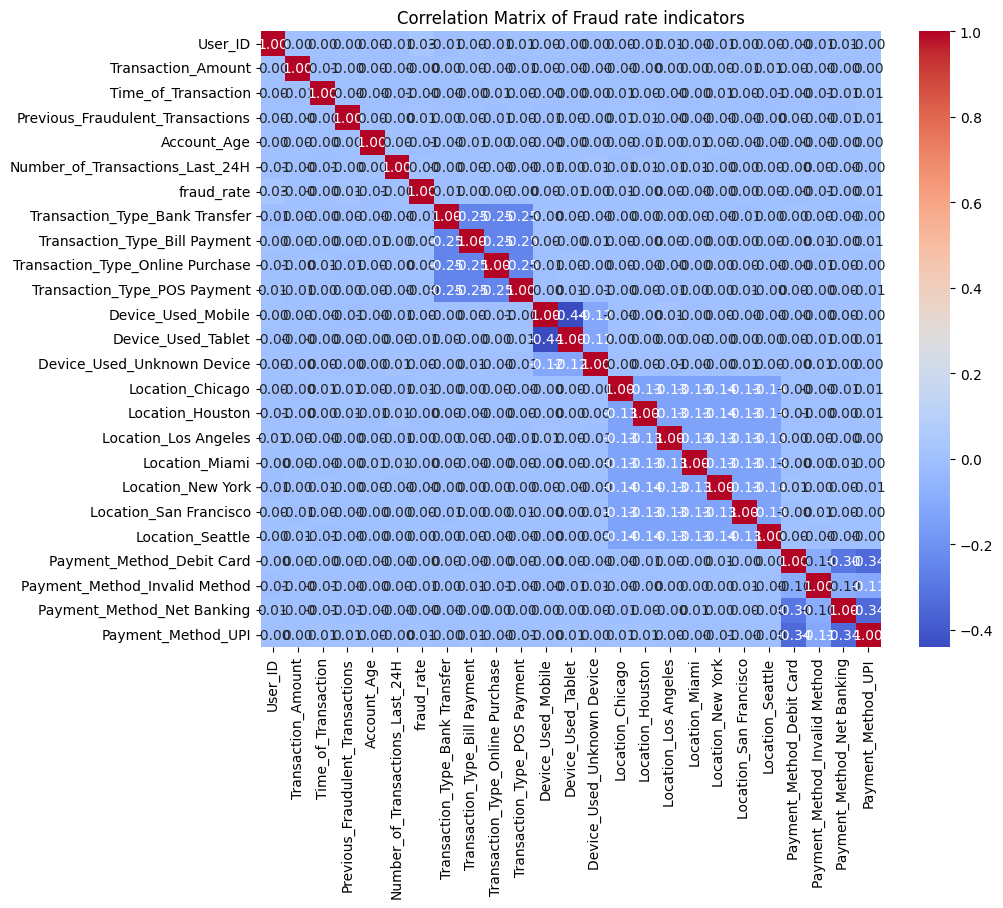

In [28]:
# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Fraud rate indicators')
plt.show()

**From the results above, I observed some level of multicollinearity between the predictor variables and less number of variables having a correlation with the response variable**

**Using the predictor variable that has a close relationship wtih fraud rate (Previous_fraudulent_transcations), I created a scatter plot to visualize the realtionship**

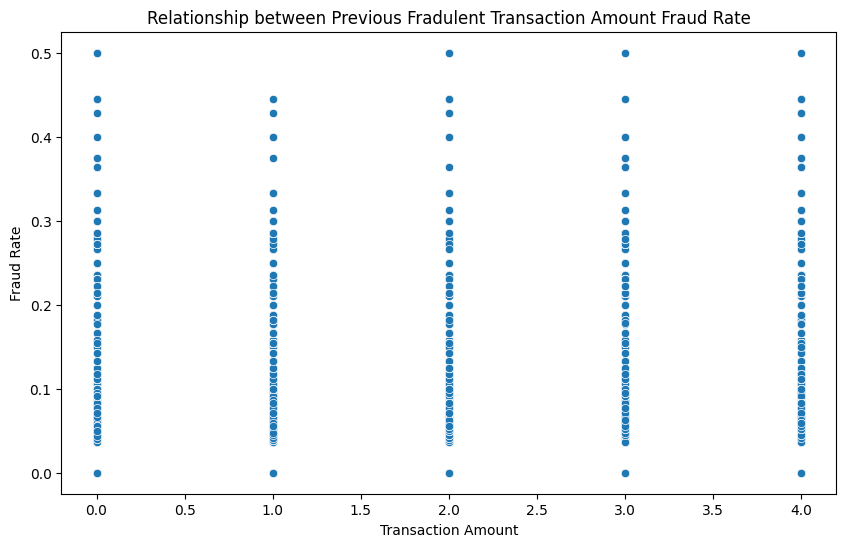

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Previous_Fraudulent_Transactions', y='fraud_rate', data=data)
plt.xlabel('Transaction Amount')
plt.ylabel('Fraud Rate')
plt.title('Relationship between Previous Fradulent Transaction Amount Fraud Rate')
plt.show()

**The result above showed a non-linear relationship therefore, I will implement a decison tree model to tackle non-linear relationship**


**Preprocessing**
Standardise the data to be of the same scale.

In [30]:
# Get the x and y variables, dropping 'fraud_rate' (the target) and 'User_ID'
x = data.drop(['fraud_rate', 'User_ID'], axis=1)
y = data['fraud_rate']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

**Split the data into train and test sets**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=1,
                                                    shuffle=False)

In [32]:
# Create DT model object
d_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
# Train the DT model
d_tree.fit(X_train, y_train)



DecisionTreeRegressor(max_depth=5, random_state=42)

In [33]:
# Fit the model
y_pred=d_tree.predict(X_test)
print(y_pred)

[0.05033563 0.04639595 0.04853365 ... 0.04853365 0.05094005 0.04639595]


**Model Accuracy**


In [34]:
mse= mean_squared_error(y_test, y_pred)
r2=r2_score(y_test, y_pred)
print("MSE:", mse)
print("R2:", r2)

MSE: 0.003776694066292765
R2: -0.006516882718893058


**Based on the results above, a negative R2 score indicates that this model does not explain any of the variance in the target variable and is performing worse than simply predicting the mean**

**I proceeded to utilise an random forest ensemble method that builds multiple decision trees during training and outputs the average of the predictions of the individual trees to make a more accurate and robust prediction.**

In [35]:
# Instantiate the random forest regressor class
ran_for= RandomForestRegressor(random_state=42)
# fit the model
ran_for.fit(X_train, y_train)
# predict the response variable based on the test set
ran_for_pred= ran_for.predict(X_test)
ran_for_pred


array([0.04709604, 0.07604025, 0.03653659, ..., 0.05534748, 0.03683966,
       0.02733336])

**Model Accuracy**

In [36]:
mse= mean_squared_error(y_test, ran_for_pred)

r2=r2_score(y_test, ran_for_pred)

print("MSE:", mse)
print("R2:", r2)

MSE: 0.0036022991111769585
R2: 0.03996066179594926


The lower MSE indicates a better fit of the model to the data.


The Random Forest model achieved an R2 score of approximately **0.0399.**

This R2 score, while positive (unlike the Decision Tree's negative R2), is still very low and indicates that the model explains only about 4% of the variance in the fraud_rate.

In practical terms:

Limited Predictive Power: The model is not very effective at capturing the patterns in the fraud_rate. It performs only marginally better than simply predicting the average fraud_rate for all transactions.

Weak Feature-Target Relationship: This low R2 suggests that the features currently in your dataset, even when used by a powerful ensemble model like Random Forest, do not have a strong predictive relationship with the fraud_rate. This aligns with the earlier correlation analysis which showed very weak correlations.

**Next Steps**
Potential for Improvement: There might be uncaptured complexities in the data, missing influential features, or a high degree of inherent noise in the fraud_rate itself that makes it difficult to predict. Further feature engineering, collection of more relevant data, or exploring entirely different modeling approaches might be necessary to achieve a higher R2 score.